In [29]:
import numpy as np
import math
import random
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from math import sqrt, pi, exp, erf
from numba import jit

In [5]:
def odefnt(A, t):
    return 3*t - A/t

Our test ode is $\frac{dx}{dt} = 3t - \frac{x}{t}$.

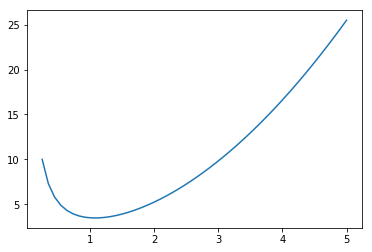

In [6]:
def model(x,t):
    return odefnt(x,t)

x0 = 10
t = np.linspace(1/4,5)
x = odeint(model,x0,t)
plt.plot(t,x)
plt.show()

Analytical solution using **odeint** which is an ode solver in python.

In [30]:
@jit
def sigma_xdot(u,v,w):
    return exp(-((u-v)**2)/(4*w**2))*sqrt(pi)*w

@jit
def cov_x(u,v,w,a,b):
    ans = pi*w**2*(u-a)*erf((u-a)/(2*w)) \
    + 2*sqrt(pi)*w**3*exp(-(u-a)**2/(4*w**2)) \
    - pi*w**2*(v-u)*erf((v-u)/(2*w)) \
    - 2*sqrt(pi)*w**3*exp(-(v-u)**2/(4*w**2)) \
    + pi*w**2*(v-a)*erf((v-a)/(2*w)) \
    + 2*sqrt(pi)*w**3*exp(-(v-a)**2/(4*w**2)) \
    - 2*sqrt(pi)*w**3;
    return ans
    #return integrate.dblquad(sigma_xdot, 0, t, lambda s: 0, lambda s: s)

@jit
def cov_xxdot(u,v,w,a,b):
    
    ans = pi*w**2*erf((v-u)/(2*w)) + pi*w**2*erf((u-a)/(2*w))
    return ans
    #return integrate.quad(sigma_xdot, 0, s, args=t)

These are the priors defined in the paper under square exponential kernel. In particular we have $R(u,v) = e^{-\frac{(u-v)^2}{2\lambda^2}}$ and $Q(u,v) =  \int\limits_0^v R(u,z) dz$ as defined in the paper. Then we have $\Sigma_{0}^{\dot{x}} = \int R(u,z)R(v,z)dz$, $\Sigma_{0}^{x} = \int Q(u,z)Q(v,z)dz$ and $\Sigma_{0}^{x,\dot{x}} = \int Q(u,z)R(v,z)dz$.

In [46]:
def baysiansolver(M,N,a,b,u):
    t = np.linspace(a,b,M)
    s = np.linspace(a,b,N)
    w = (b-a)/(N-1)
    alpha = N/10

    A = u
    B = odefnt(A, s[1])
    mu_B = np.array([0]*N)
    mu_A = u + mu_B
    
    @jit
    def sigma_0(N,s,w,a,b,alpha):
        sigma_B = np.zeros((N, N))
        sigma_A = np.zeros((N, N))
        sigma_XB = np.zeros((N, N))
        for i in range(N):
            for j in range(N):
                sigma_B[j][i] = sigma_xdot(s[i], s[j],w)/alpha
                sigma_A[j][i] = cov_x(s[i], s[j], w, a, b)/alpha
                sigma_XB[j][i] = cov_xxdot(s[i], s[j], w, a, b)/alpha
        return sigma_B, sigma_A, sigma_XB
    sigma_B, sigma_A, sigma_XB = sigma_0(N,s,w,a,b,alpha)

    for i in range(N):
        A = np.random.normal(mu_A[i], sigma_A[i,i])
        B = odefnt(A, s[i])
        mu_A = mu_A + sigma_XB[:,i]*1/sigma_B[i,i] *(B - mu_B[i])
        mu_B = mu_B + sigma_B[:,i]*(B-mu_B[i])*1/sigma_B[i,i]
        sigma_A = sigma_A - 1/sigma_B[i,i]*np.outer(sigma_XB[:,i], sigma_XB[:,i])
        sigma_XB = sigma_XB - 1/sigma_B[i,i]*np.outer(sigma_XB[:,i], sigma_B[i,:])
        sigma_B = sigma_B - 1/sigma_B[i,i]*np.outer(sigma_B[:,i], sigma_B[i,:])

    return t, np.random.multivariate_normal(mu_A, sigma_A)


C:\Users\mohan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: covariance is not positive-semidefinite.
C:\Users\mohan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: covariance is not positive-semidefinite.
C:\Users\mohan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: covariance is not positive-semidefinite.


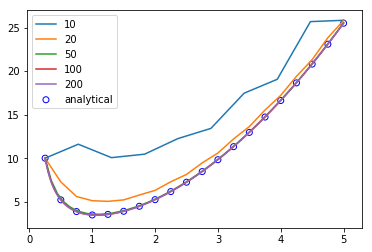

In [60]:
discretion_size = [10,20, 50, 100, 200]
for d in discretion_size:
    t, u_all= baysiansolver(d, d, 1/4, 5, 10)
    plt.plot(t,u_all, label = '{}'.format(d))
    plt.legend(loc='upper left')


x0 = 10
t = np.linspace(1/4,5, 20)
x = odeint(model,x0,t)
plt.scatter(t, x, facecolor = 'none', edgecolor = 'b', label='analytical')
plt.legend(loc='upper left')
plt.show()

For this simple ode, a discretization size of 50 gives a solution close enough to the analytical solution.